In [16]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import lina
print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [2]:
scoobi.home_block(client0)

In [3]:
scoobi.move_block_out(client0)

In [3]:
reload(scoobi)
xc, yc = (4910, 3400)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [17]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')

# Do the normalization

In [24]:
scoobi.move_psf(-50, 0, client0)

In [25]:
reload(scoobi)
I.set_zwo_exp_time(0.000120, client0)

Set the ZWO exposure time to 1.20e-04s


In [15]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [29]:
reload(scoobi)
I.set_fib_atten(34, client)

Set the fiber attenuation to 34.0


34125.88


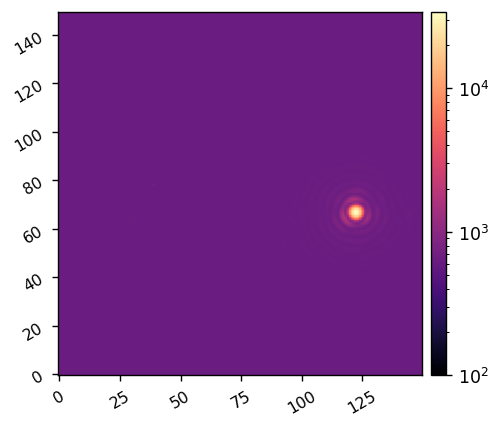

In [31]:
I.NSCICAM = 200
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [32]:
I.ref_psf_params = {
    'ref_psf':copy.copy(ref_psf),
    'Imax': copy.copy(xp.max(ref_psf)),
    'texp': copy.copy(I.texp), 
    'atten': copy.copy(I.atten),
    'gain': copy.copy(I.gain),
}
utils.save_pickle(f'../data/{today}_ref_psf_params.pkl', I.ref_psf_params)

Saved data to:  ../data/20241024_ref_psf_params.pkl


In [54]:
I.reset_dm()

In [43]:
scoobi.move_psf(1, 0, client0)

In [50]:
scoobi.move_psf(0, -1, client0)

In [51]:
I.set_fib_atten(8, client)

Set the fiber attenuation to 8.0


In [52]:
I.set_zwo_exp_time(0.0005, client0)

Set the ZWO exposure time to 5.00e-04s


In [53]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


# Make a function to adjust bias on the camera
camsci.blacklevel.target

In [55]:
reload(scoobi)
scoobi.move_block_in(client0)

Saved data to:  ../data/20241024_camsci_dark_frame.fits


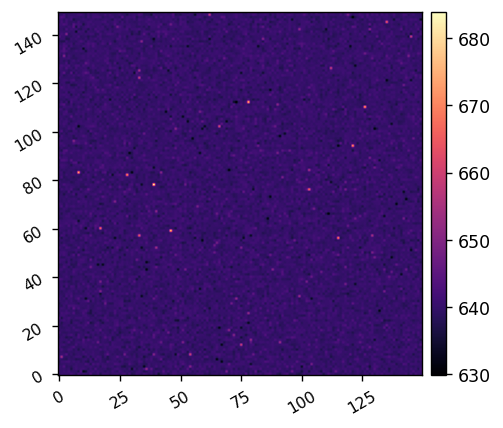

In [57]:
# I.NSCICAM = 200
# I.subtract_dark = False
# I.return_ni = False
# dark_frame = I.snap()
# utils.save_fits(f'../data/{today}_camsci_dark_frame.fits', dark_frame, header={'EXPTIME':I.texp, 'GAIN':I.gain, 'ATTEN':I.atten})

dark_frame = utils.load_fits(f'../data/{today}_camsci_dark_frame.fits')
I.df = copy.copy(dark_frame)
imshow1(dark_frame)

In [58]:
reload(scoobi)
scoobi.move_block_out(client0)

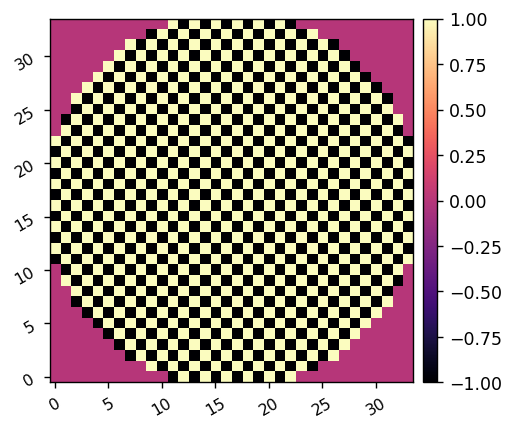

In [59]:
reload(scoobi.utils)
waffle_command = scoobi.utils.create_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

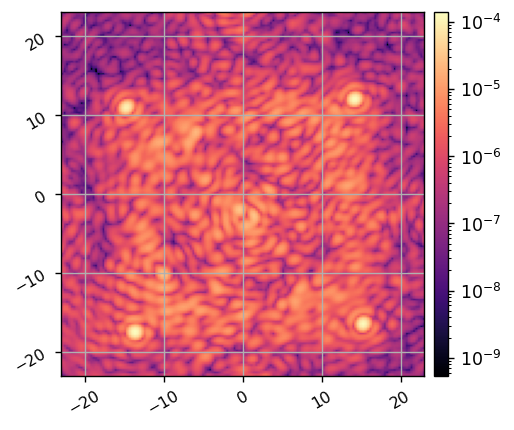

In [60]:
I.set_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

I.NSCICAM = 100
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamD, grid=True)

Centroids:
 [[ 30.01930648  17.69359363]
 [ 26.51291445 110.24417112]
 [120.59301671 113.5598225 ]
 [124.02703992  21.01134368]
 [ 30.01930648  17.69359363]]


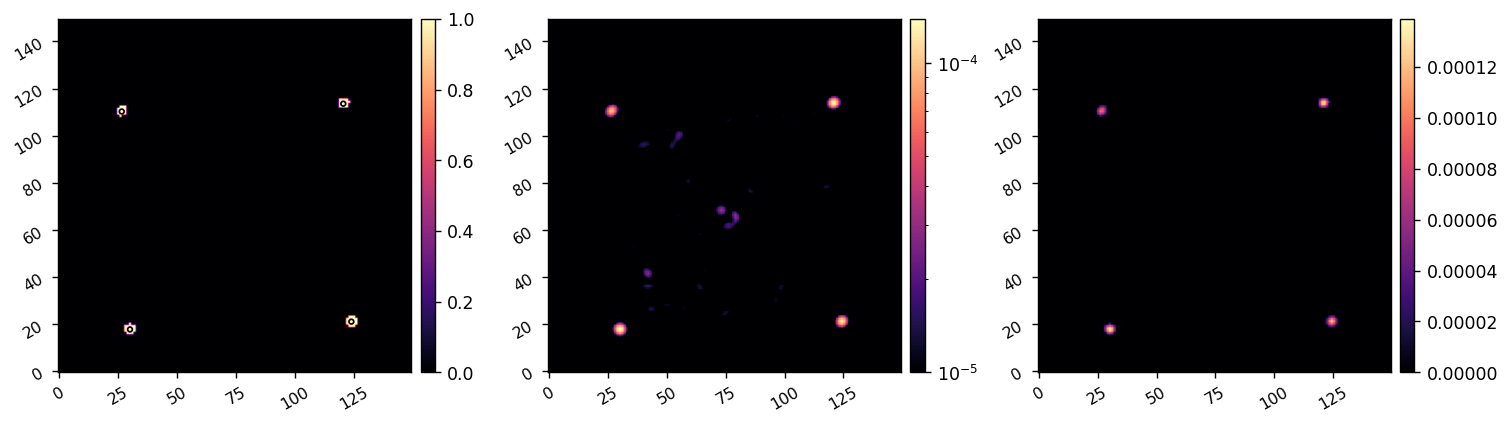

Angle:  87.91640789142505
Measured center in X:  75.28991533272247
Measured center in Y:  65.60951248161723
Required shift in X:  -0.0
Required shift in Y:  9.0


In [63]:
reload(scoobi.utils)

xshift,yshift,angle = scoobi.utils.measure_center_and_angle(waffle_im, I.psf_pixelscale_lamD, im_thresh=3e-5, r_thresh=16)

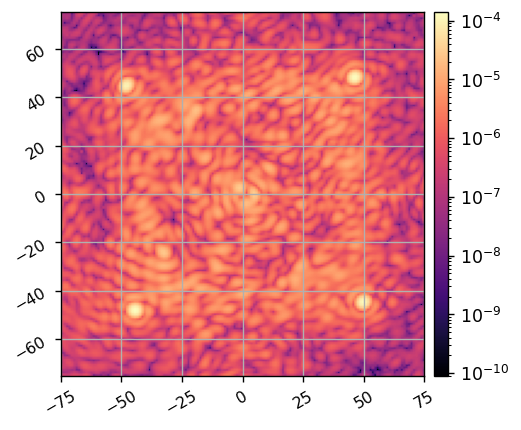

In [64]:
I.Nframes = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift

I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

In [65]:
I.zero_dm()

# Choose modes and probes for iEFC

In [66]:
reload(lina.utils)

iwa = 2.5
owa = 12
rotation = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

1.8592694620854503e-06


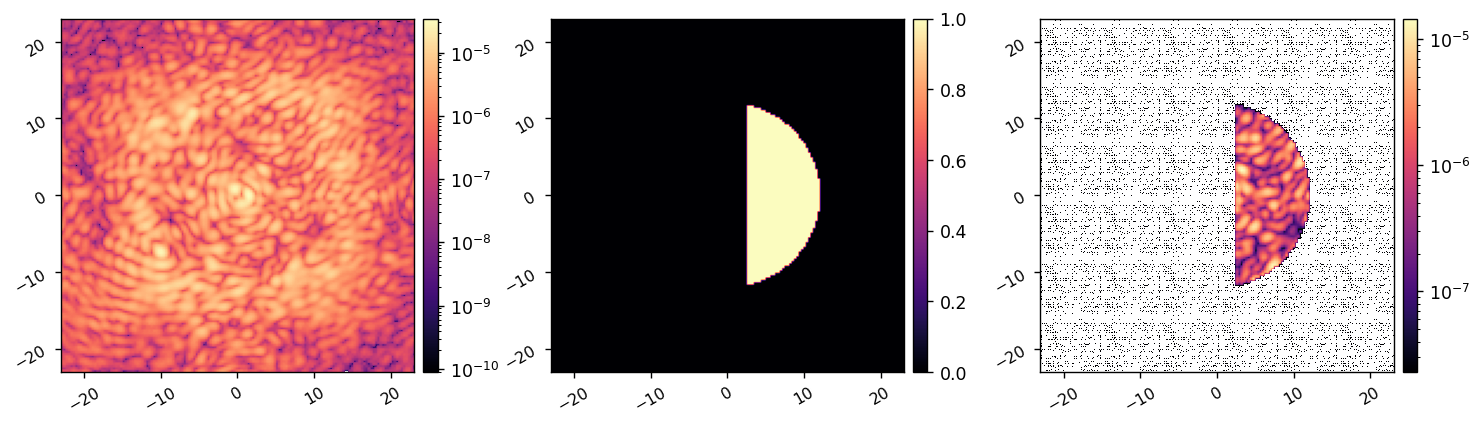

Saved data to:  ../data/20241024_ref_coro_im.fits


In [68]:
I.zero_dm()
I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True
# I.set_zwo_exp_time(0.0005, client0)

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamD)
lina.utils.save_fits(f'../data/{today}_ref_coro_im.fits', ref_coro_im)

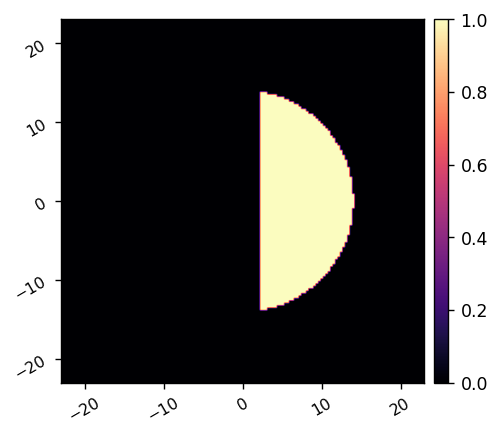

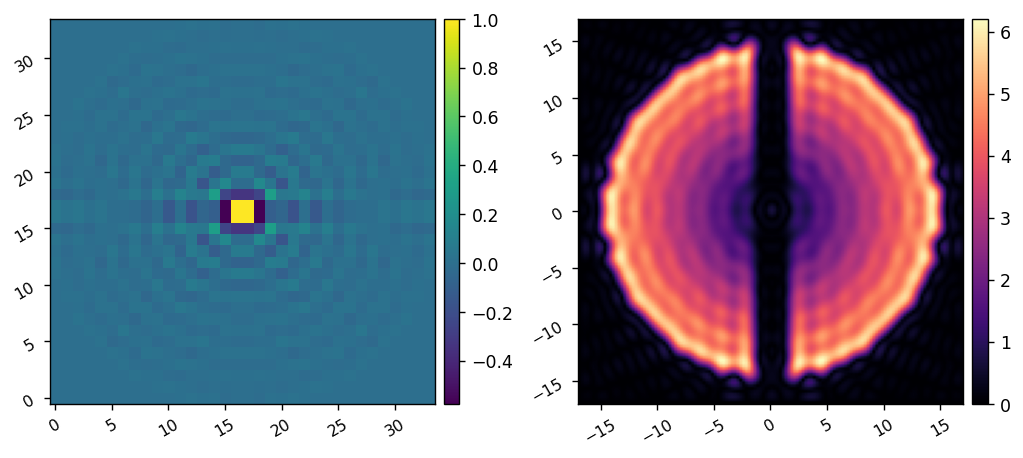

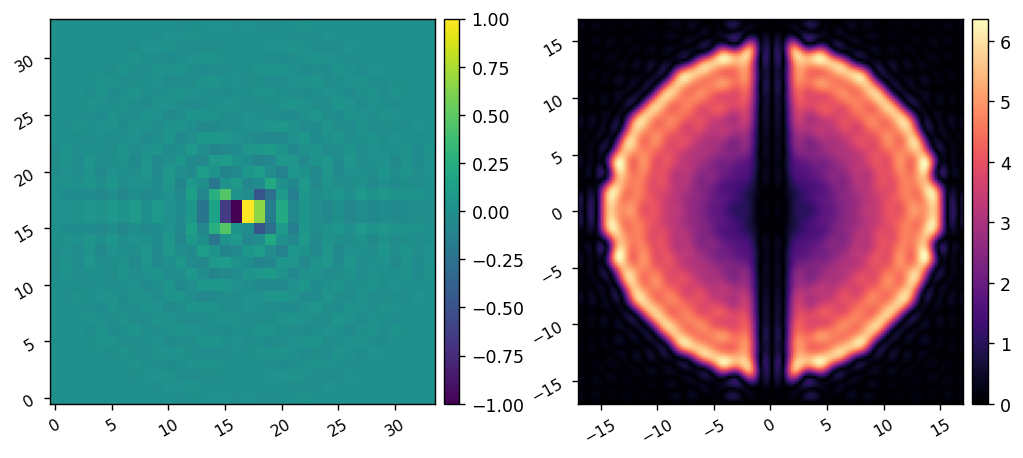

In [69]:
reload(lina.utils)
probe_iwa = 2
probe_owa = 14
probe_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, probe_iwa, probe_owa, edge=probe_iwa)
imshow1(probe_mask, pxscl=I.psf_pixelscale_lamD)
probe_modes = lina.utils.create_fourier_probes(xp.array(I.dm_mask), I.npsf, I.psf_pixelscale_lamD, probe_iwa, probe_owa, rotation=0,
                                               fourier_sampling=0.75, 
                                                shifts=None, 
                                                nprobes=2,
                                                use_weighting=True, 
                                                plot=True,
                                               )

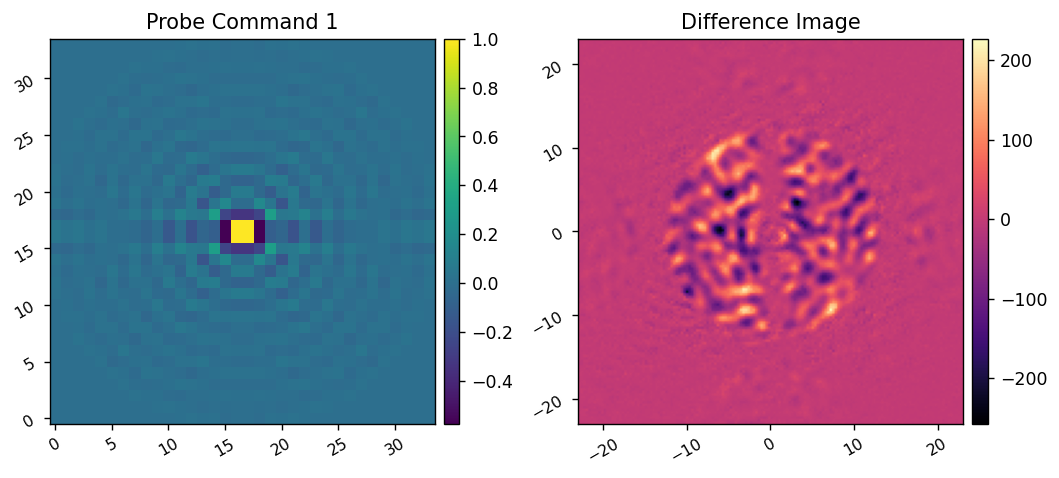

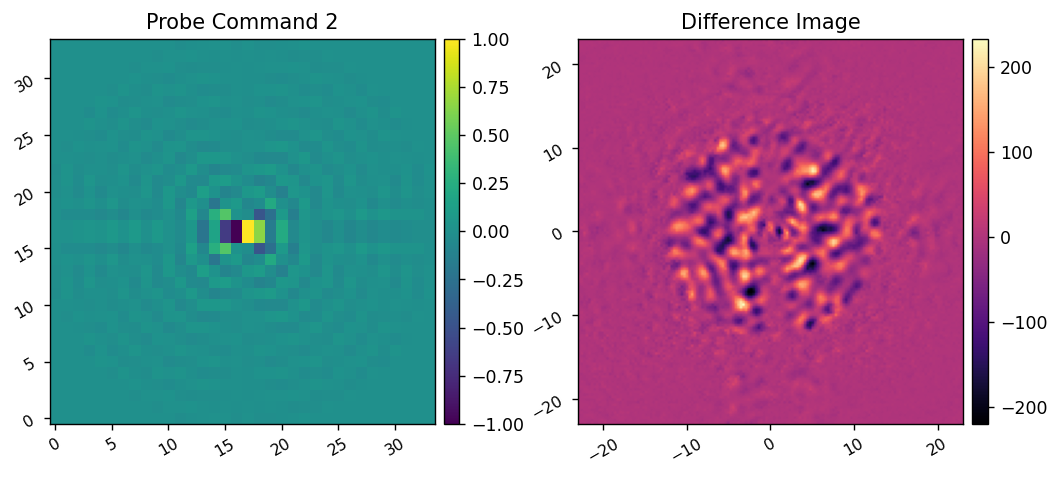

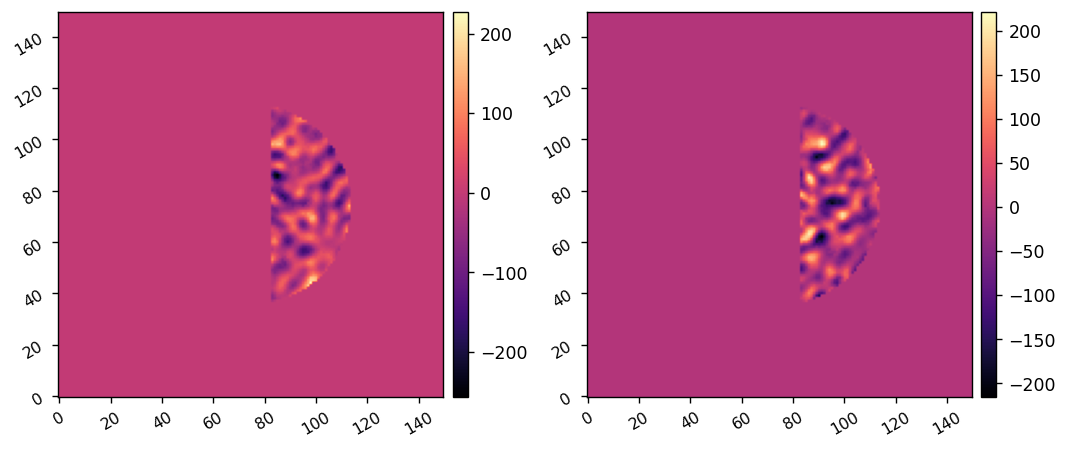

In [70]:
reload(lina.iefc)

I.NSCICAM = 30
I.subtract_dark = False
I.return_ni = True
diff_ims = lina.iefc.take_measurement(I, probe_modes, 5e-9, plot=True)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

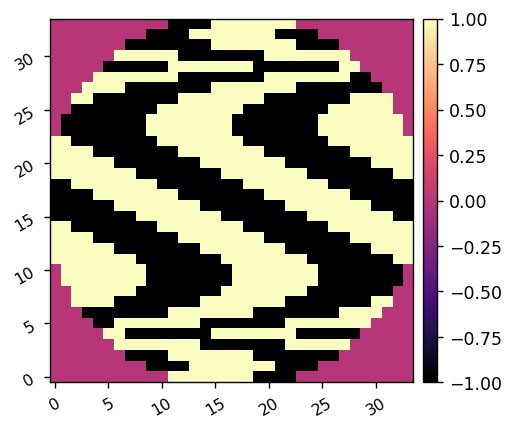

In [71]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(I.dm_mask))
imshow1(calib_modes[8])


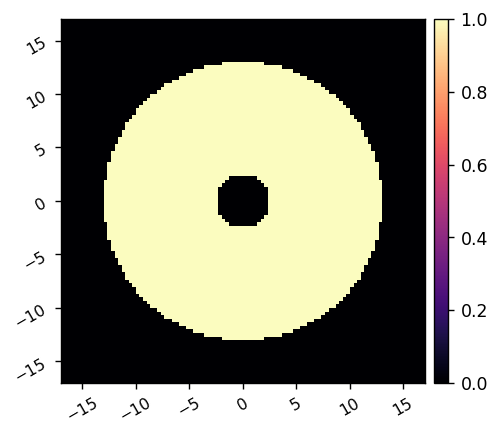

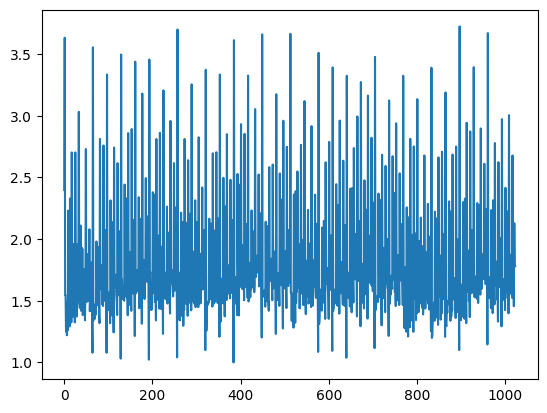

[1.26141126 2.2314004  1.69366311 1.7770875 ]


In [72]:
reload(lina.iefc)
scale_factors = lina.iefc.compute_hadamard_scale_factors(calib_modes, scale_exp=1/5, scale_thresh=4, oversamp=3, plot=True)
print(scale_factors[8:12])

In [82]:
reload(lina.iefc)
I.zero_dm()

probe_amp = 5e-9
calib_amp = 2.5e-9

I.NSCICAM = 10
I.return_ni = True
I.subtract_dark = False
I.dm_delay = I.texp * 3
print(I.dm_delay)

# time.sleep(2)
response_matrix, response_cube = lina.iefc.calibrate(I, control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, scale_factors=scale_factors, 
                                                    #  calib_amp, calib_modes[100:110], 
                                                    #  scale_factors=scale_factors[100:110], 
                                                    #  calib_amp, calib_modes[8:12], 
                                                    #  scale_factors=scale_factors[8:12], 
                                                     return_all=True,
                                                     )

0.0015
Calibrating iEFC...
	Calibrated mode 1024/1024 in 629.383s
Calibration complete.


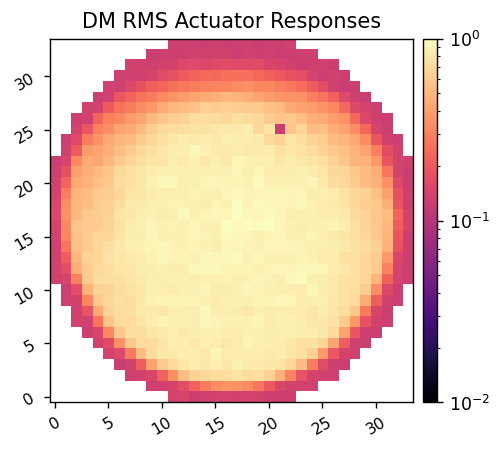

In [84]:
dm_response_map = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes.reshape(1024, -1))), axis=0))
dm_response_map = dm_response_map.reshape(I.Nact,I.Nact) / xp.max(dm_response_map)
imshow1(dm_response_map, 'DM RMS Actuator Responses', lognorm=True, vmin=1e-2)

In [83]:
lina.utils.save_fits(f'../data/{today}_iefc_probes.fits', probe_modes)
# lina.utils.save_fits(f'../data/{today}_iefc_hadamard_jac_cube_W_wfe_WO_llowfsc.fits', response_cube)
# lina.utils.save_fits(f'../data/{today}_iefc_hadamard_jac_cube_WO_wfe_W_llowfsc.fits', response_cube)
lina.utils.save_fits(f'../data/{today}_iefc_hadamard_jac_cube_W_wfe_W_llowfsc.fits', response_cube)

Saved data to:  ../data/20241024_iefc_probes.fits
Saved data to:  ../data/20241024_iefc_hadamard_jac_cube_W_wfe_W_llowfsc.fits


In [85]:
response_cube = utils.load_fits(f'../data/{today}_iefc_hadamard_jac_cube_W_wfe_WO_llowfsc.fits')
# response_cube = utils.load_fits(f'../data/{today}_iefc_hadamard_jac_cube_WO_wfe_W_llowfsc.fits')
# response_cube = utils.load_fits(f'../data/{today}_iefc_hadamard_jac_cube_W_wfe_W_llowfsc.fits')
response_matrix = response_cube[:, :, control_mask.ravel()].reshape(1024, -1).T

In [86]:
I.zero_dm()
all_ims = []
all_commands = []

0.15000000000000002
Running iEFC...
	Closed-loop iteration 10 / 12
(1024, 1156) (1024,)


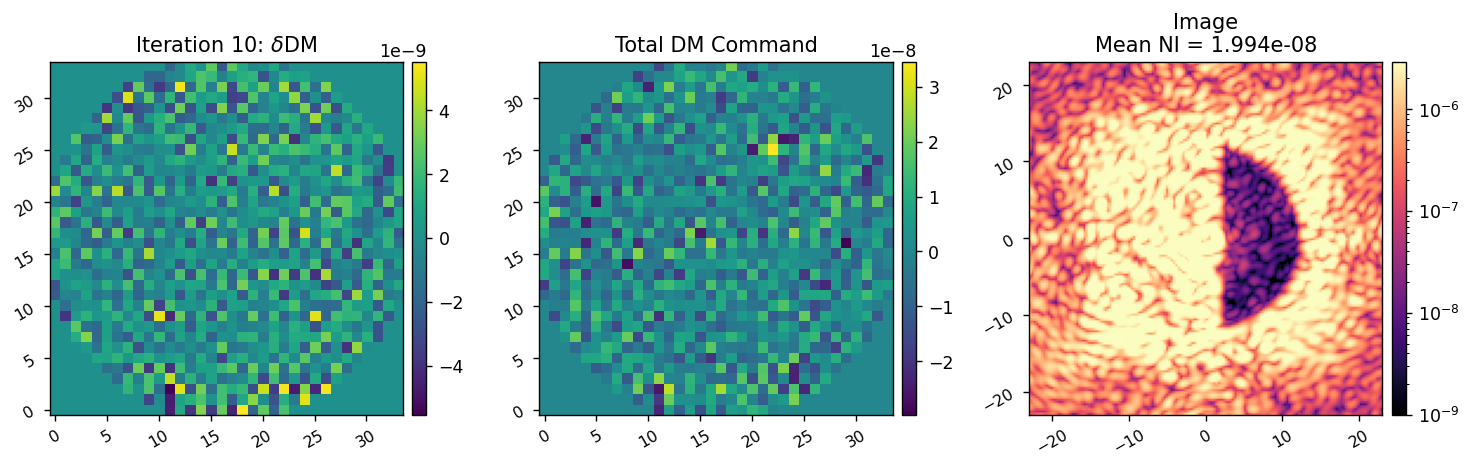

	Closed-loop iteration 11 / 12
(1024, 1156) (1024,)


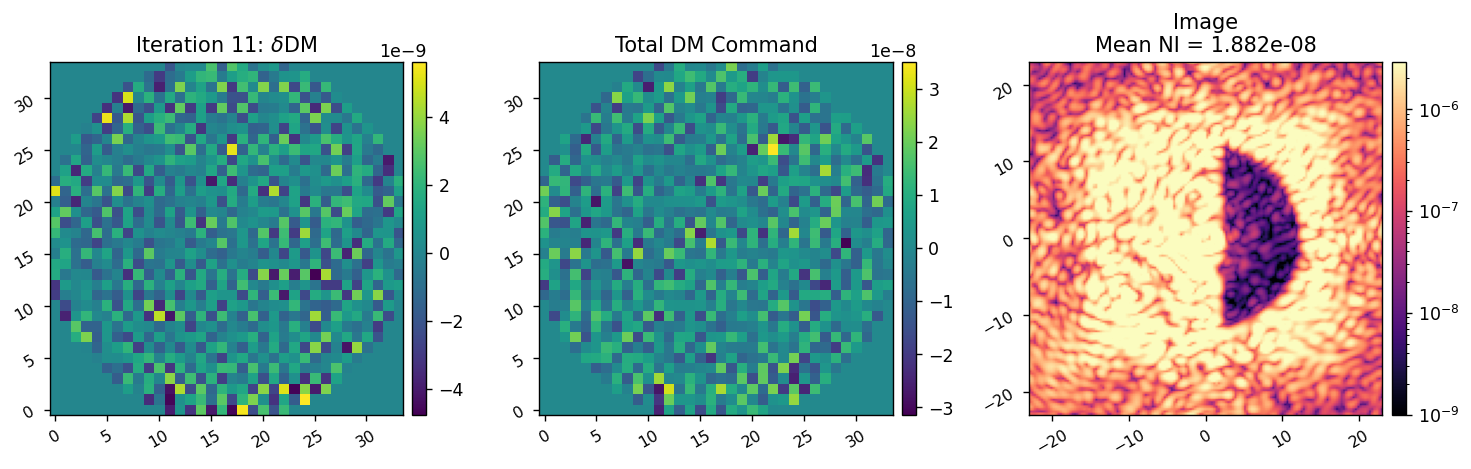

	Closed-loop iteration 12 / 12
(1024, 1156) (1024,)


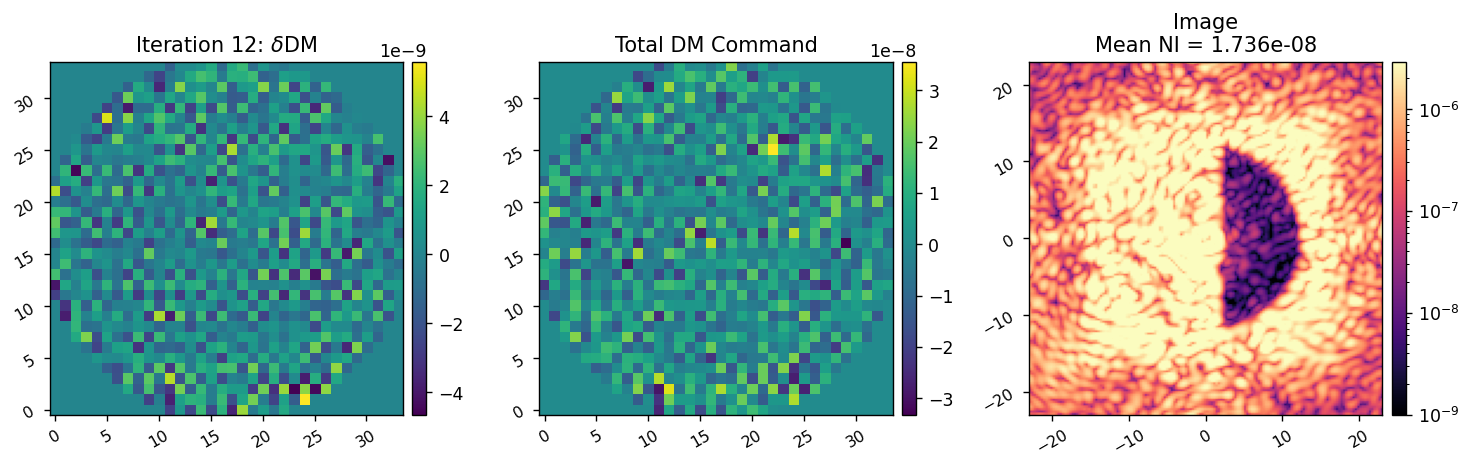

Closed loop for given control matrix completed in 39.257s.


In [97]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(response_matrix, -2.5)
# cm = lina.utils.beta_reg(response_matrix, -3.5)
cm = lina.utils.beta_reg(response_matrix, -5)

probe_amp = 5e-9
probe_amp = 4e-9
# probe_amp = 3e-9
probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
# probe_amp = 1e-9

I.NSCICAM = 40
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

all_ims, all_commands = lina.iefc.run(I,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims,
                                        all_commands=all_commands,
                                        )

In [91]:
I.set_zwo_exp_time(0.05, client0, delay=1)
I.set_zwo_gain(120, client0)

Set the ZWO exposure time to 5.00e-02s
Set the ZWO gain setting to 120.0


In [92]:
reload(scoobi)
scoobi.move_block_in(client0)

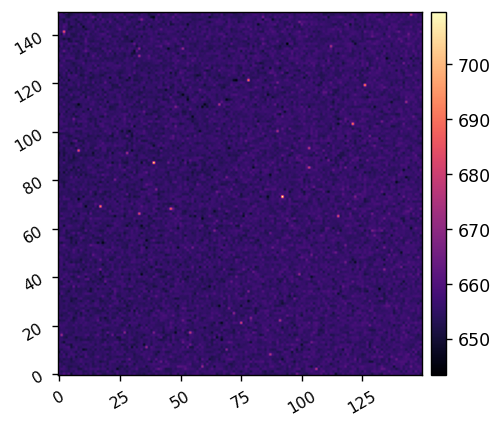

In [93]:
I.NSCICAM = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

In [95]:
reload(scoobi)
scoobi.move_block_out(client0)

2.124156796370502e-08


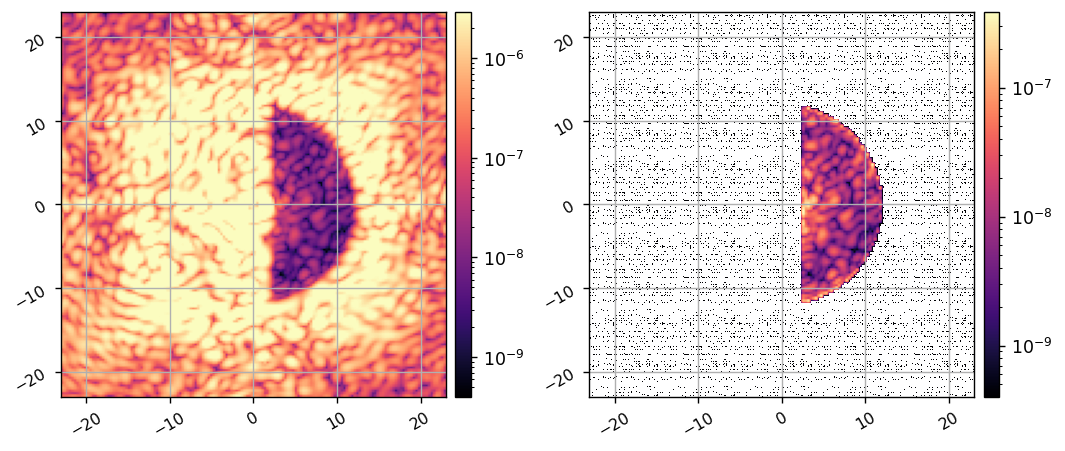

In [96]:
I.NSCICAM = 20
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im, grid=True, lognorm=True, pxscl=I.psf_pixelscale_lamD)

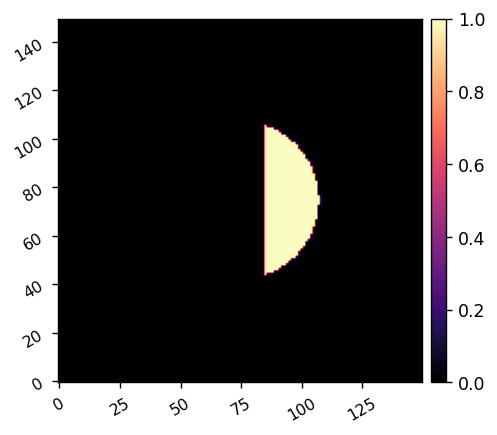

In [99]:
new_iwa = 3
new_owa = 10
new_control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, new_iwa, new_owa, edge=new_iwa, rotation=rotation)
imshow1(new_control_mask)

In [100]:
new_response_matrix = response_cube[:, :, new_control_mask.ravel()].reshape(1024, -1).T
new_response_matrix.shape

(2044, 1024)

0.15000000000000002
Running iEFC...
	Closed-loop iteration 25 / 27
(1024, 1156) (1024,)


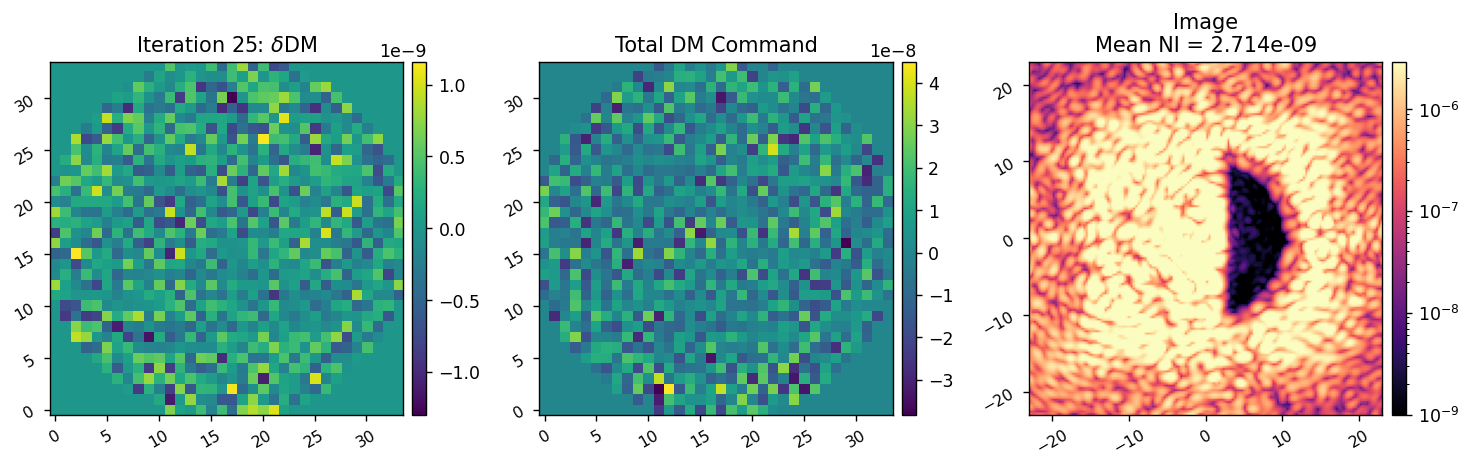

	Closed-loop iteration 26 / 27
(1024, 1156) (1024,)


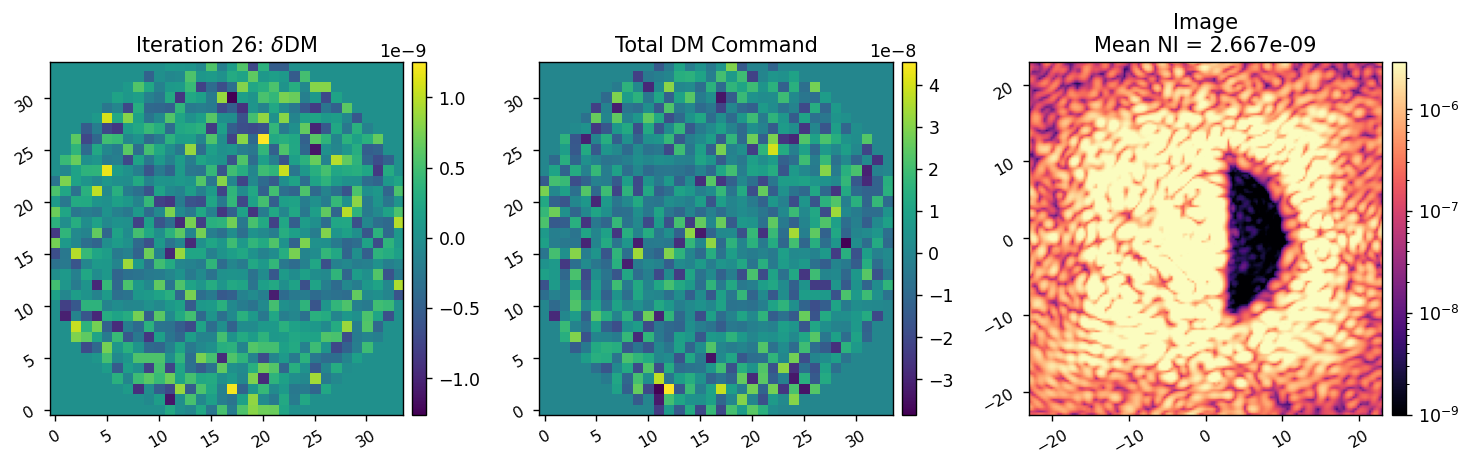

	Closed-loop iteration 27 / 27
(1024, 1156) (1024,)


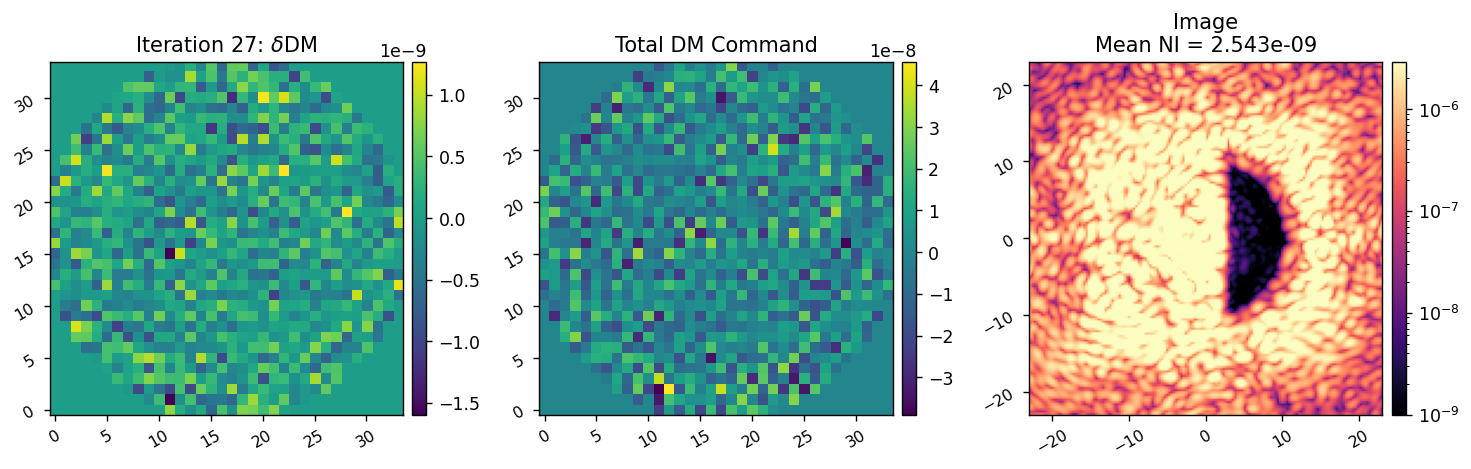

Closed loop for given control matrix completed in 39.338s.


In [112]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(new_response_matrix, -2.5)
# cm = lina.utils.beta_reg(new_response_matrix, -3.5)
# cm = lina.utils.beta_reg(new_response_matrix, -5)

probe_amp = 5e-9
# probe_amp = 4e-9
probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
probe_amp = 1e-9
probe_amp = 0.75e-9
# probe_amp = 0.5e-9

I.NSCICAM = 40
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

all_ims, all_commands = lina.iefc.run(I,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        new_control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims, 
                                        all_commands=all_commands,
                                        )

In [115]:
lina.utils.save_fits(f'../data/{today}_iefc_hadamard_ims.fits', xp.array(all_ims))
lina.utils.save_fits(f'../data/{today}_iefc_hadamard_commands.fits', xp.array(all_commands))
lina.utils.save_fits(f'../data/{today}_iefc_control_mask_1.fits', control_mask.astype(int))
lina.utils.save_fits(f'../data/{today}_iefc_control_mask_2.fits', new_control_mask.astype(int))


Saved data to:  ../data/20241024_iefc_hadamard_ims.fits
Saved data to:  ../data/20241024_iefc_hadamard_commands.fits
Saved data to:  ../data/20241024_iefc_control_mask_1.fits
Saved data to:  ../data/20241024_iefc_control_mask_2.fits


In [130]:
I.set_zwo_exp_time(0.05, client0, delay=1)
I.set_zwo_gain(120, client0)
I.Nframes = 10

Set the ZWO exposure time to 5.00e-02s
Set the ZWO gain setting to 120.0


In [131]:
reload(scoobi)
scoobi.move_block_in(client0)

In [133]:
reload(scoobi)
scoobi.move_block_out(client0)

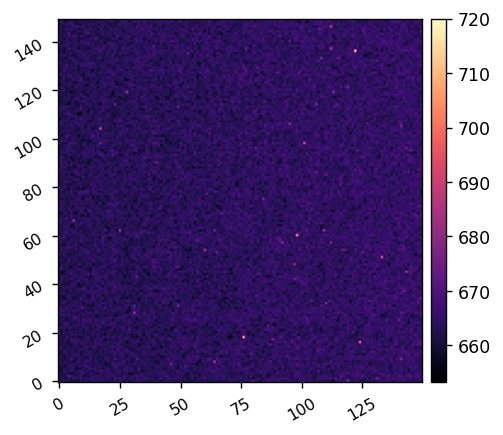

In [132]:
I.NSCICAM = 50
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

2.592646966064342e-09


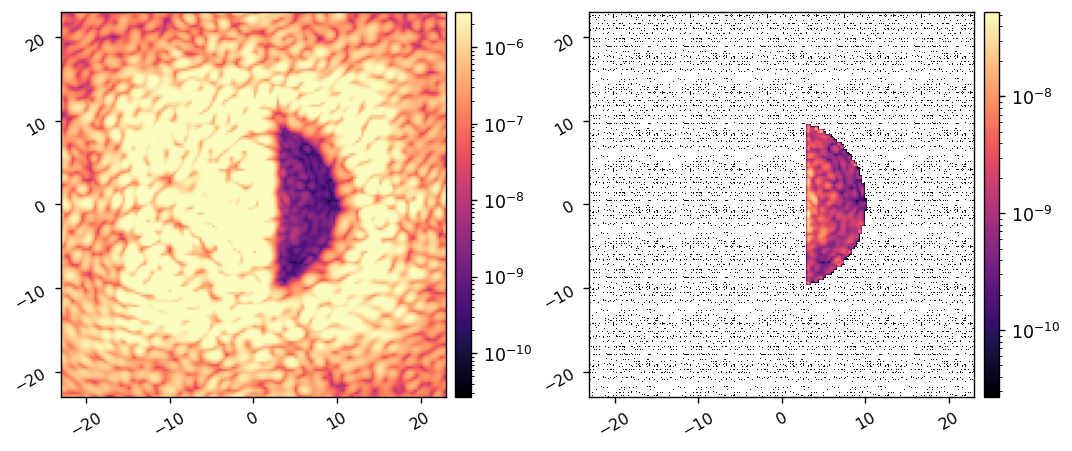

In [113]:
I.NSCICAM = 40
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[new_control_mask]))
imshow2(coro_im, new_control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamD)

In [119]:
I.set_fib_atten(8, client0)

ValueError: Attempting to set read-only property atten.target to 8

# Monitor the dark hole

In [114]:
reload(scoobi)
from pathlib import Path

duration = 300
# duration = 60
I.NSCICAM = 40

# time.sleep(5)
scoobi.stream_scicam(I, 
                     duration=duration, 
                     control_mask=new_control_mask, 
                    #  plot=True, 
                    #  clear=True, 
                     save_data_to=Path(f'../camsci-streams/{today}_ims_with_llowfsc_with_wfe_3.fits'),
                     )

Saved data to:  ../camsci-streams/20241024_ims_with_llowfsc_with_wfe_3.fits


In [149]:
modal_matrix = had_modes.reshape(1024, -1)

In [148]:
camsci_data = lina.utils.load_fits(f'camsci-streams/{today}_ims_without_llowfsc.fits')
camsci_data.shape

(1794, 150, 150)

In [169]:
I.zero_dm()

# Run iEFC in an automatic loop

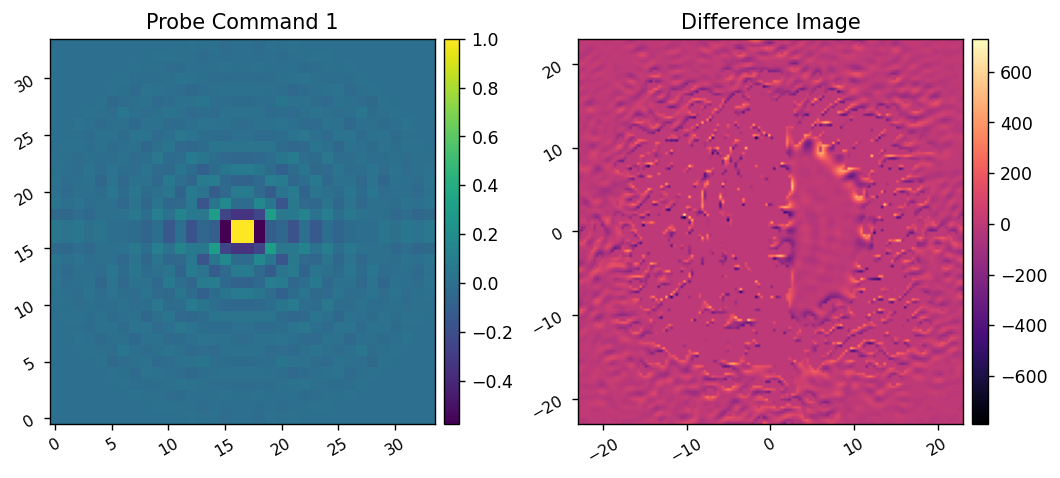

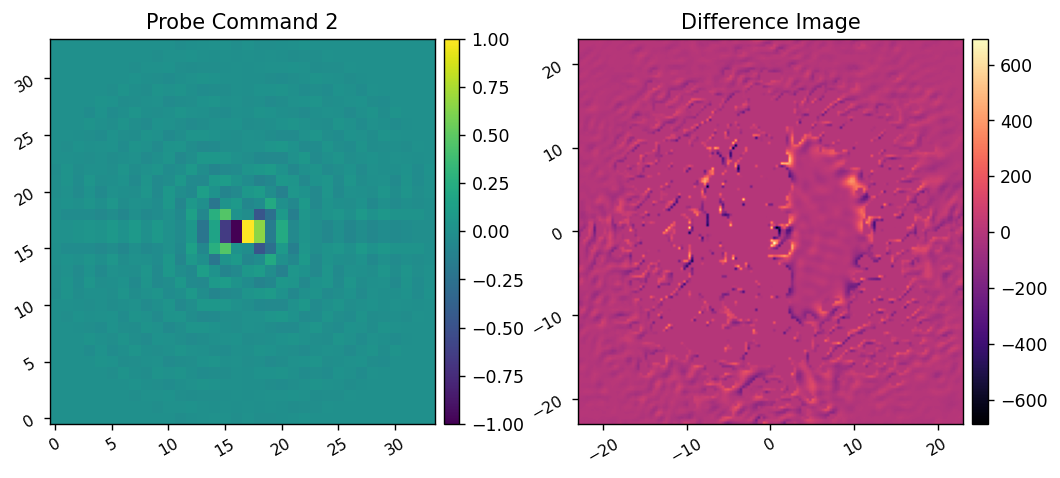

(1024, 2044) (2044,)


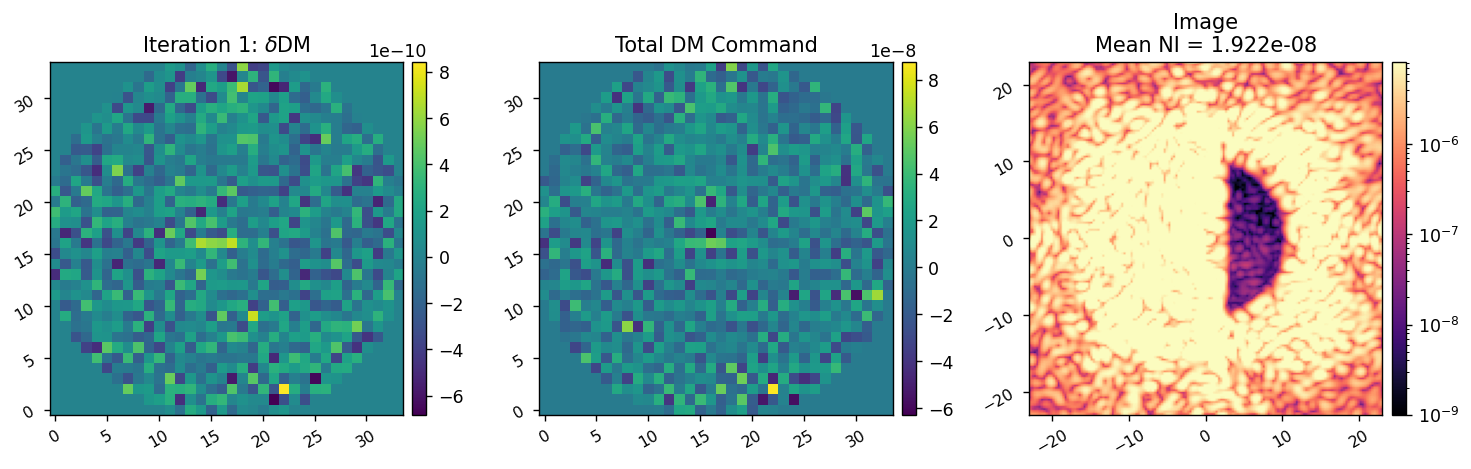

In [105]:
reload(lina.iefc)
probe_amp = 1e-9
modal_matrix = calib_modes.reshape(1024, -1)
cm = lina.utils.beta_reg(new_response_matrix, -2.5)

lina.iefc.run_iteration(I, probe_modes, probe_amp, cm, modal_matrix, new_control_mask, gain=0.5, plot=True, plot_probes=True)

In [109]:
reload(lina.iefc)
iefc_interval = 300
I.dm_delay = 2*I.texp

probe_amp = 1e-9
modal_matrix = calib_modes.reshape(1024, -1)
cm = lina.utils.beta_reg(new_response_matrix, -2.5)

args = [I, probe_modes, probe_amp, cm, modal_matrix, new_control_mask]
kwargs = {
    'gain':0.5,
    'plot':True,
    # 'plot_probes':True,
    # 'clear':False, 
}

iefc_process = lina.utils.Process(iefc_interval, 
                                       lina.iefc.run_iteration, 
                                       args, # the args
                                       kwargs, # the kwargs
                                       )

In [110]:
iefc_process.start()

In [114]:
iefc_process.cancel()

In [116]:
I.zero_dm()

In [118]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s
